In [21]:
# This is needed for deferring annotation parsing in TVMScript
from __future__ import annotations
import IPython
import numpy as np
import tvm
from tvm import relax
from tvm.ir.module import IRModule
from tvm.script import relax as R
from tvm.script import tir as T

In [22]:
import torch
import torchvision

test_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

img, label = next(iter(test_loader))
img = img.reshape(1, 28, 28).numpy()

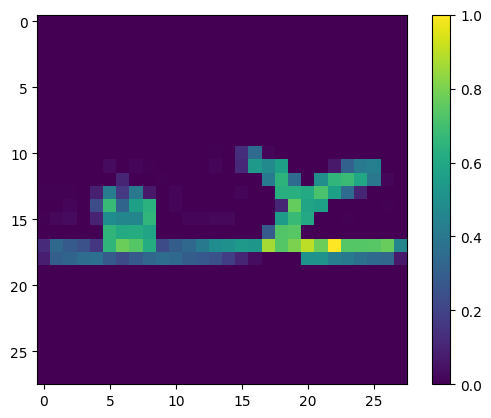

Class: Sandal


In [23]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(img[0])
plt.colorbar()
plt.grid(False)
plt.show()
print("Class:", class_names[label[0]])

In [24]:
# Hide outputs
!wget https://github.com/mlc-ai/web-data/raw/main/models/fasionmnist_mlp_params.pkl

--2022-10-24 12:32:09--  https://github.com/mlc-ai/web-data/raw/main/models/fasionmnist_mlp_params.pkl
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... No data received.
Retrying.

--2022-10-24 12:32:25--  (try: 2)  https://github.com/mlc-ai/web-data/raw/main/models/fasionmnist_mlp_params.pkl
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mlc-ai/web-data/main/models/fasionmnist_mlp_params.pkl [following]
--2022-10-24 12:32:26--  https://raw.githubusercontent.com/mlc-ai/web-data/main/models/fasionmnist_mlp_params.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 0.0.0.0, ::
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|0.0.0.0|:443... failed: Connection refused.
Connecting to raw.githubusercontent.com (raw.githubus

numpy实现

In [25]:
def numpy_mlp(data, w0, b0, w1, b1):
    lv0 = data @ w0.T + b0
    lv1 = np.maximum(lv0, 0)
    lv2 = lv1 @ w1.T + b1
    return lv2

In [26]:
import pickle as pkl

mlp_params = pkl.load(open("fasionmnist_mlp_params.pkl", "rb"))
res = numpy_mlp(img.reshape(1, 784),
                mlp_params["w0"],
                mlp_params["b0"],
                mlp_params["w1"],
                mlp_params["b1"])

print(res)
pred_kind = res.argmax(axis=1)
print(pred_kind)
print("NumPy-MLP Prediction:", class_names[pred_kind[0]])

[[-14.925779 -19.323433  -4.577471  -7.84218   -9.864161  15.604654
  -10.957133 -11.798821  -5.615505 -21.85676 ]]
[5]
NumPy-MLP Prediction: Sandal


In [27]:
def lnumpy_linear0(X: np.ndarray, W: np.ndarray, B: np.ndarray, Z: np.ndarray):
    Y = np.empty((1, 128), dtype="float32")
    for i in range(1):
        for j in range(128):
            for k in range(784):
                if k == 0:
                    Y[i, j] = 0
                Y[i, j] = Y[i, j] + X[i, k] * W[j, k]
    
    for i in range(1):
        for j in range(128):
            Z[i, j] = Y[i, j] + B[j]

def lnumpy_relu0(X: np.ndarray, Y: np.ndarray):
    for i in range(1):
        for j in range(128):
            Y[i, j] = np.maximum(X[i, j], 0)


def lnumpy_linear1(X: np.ndarray, W: np.ndarray, B: np.ndarray, Z: np.ndarray):
    Y = np.empty((1, 10), dtype="float32")
    for i in range(1):
        for j in range(10):
            for k in range(128):
                if k == 0:
                    Y[i, j] = 0
                Y[i, j] = Y[i, j] + X[i, k] * W[j, k]
    
    for i in range(1):
        for j in range(10):
            Z[i, j] = Y[i, j] + B[j]

def lnumpy_mlp(data, w0, b0, w1, b1):
    lv0 = np.empty((1, 128), dtype="float32")
    lnumpy_linear0(data, w0, b0, lv0)

    lv1 = np.empty((1, 128), dtype="float32")
    lnumpy_relu0(lv0, lv1)

    out = np.empty((1, 10), dtype="float32")
    lnumpy_linear1(lv1, w1, b1, out)
    return out

result = lnumpy_mlp(img.reshape(1, 784),
                    mlp_params["w0"],
                    mlp_params["b0"],
                    mlp_params["w1"],
                    mlp_params["b1"])

pred_kind = result.argmax(axis=1)
print("Low-level Numpy MLP Prediction:", class_names[pred_kind[0]])

Low-level Numpy MLP Prediction: Sandal


在TVMScript中构建端到端IRModule

In [29]:
@tvm.script.ir_module
class MyModule:
    @T.prim_func
    def relu0(X: T.Buffer[(1, 128), "float32"],
              Y: T.Buffer[(1, 128), "float32"]):
        # function attr dict
        T.func_attr({"global_symbol": "relu0", "tir.noalias": True})
        for i, j in T.grid(1, 128):
            with T.block("Y"):
                vi, vj = T.axis.remap("SS", [i, j])
                Y[vi, vj] = T.max(X[vi, vj], T.float32(0))

    @T.prim_func
    def linear0(X: T.Buffer[(1, 784), "float32"],
                W: T.Buffer[(128, 784), "float32"],
                B: T.Buffer[(128,), "float32"],
                Z: T.Buffer[(1, 128), "float32"]):
        T.func_attr({"global_symbol": "linear0", "tir.noalias": True})
        Y = T.alloc_buffer((1, 128), "float32")
        for i, j, k in T.grid(1, 128, 784):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]

        for i, j in T.grid(1, 128):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                Z[vi, vj] =  Y[vi, vj] + B[vj]

    @T.prim_func
    def linear1(X: T.Buffer[(1, 128), "float32"],
                W: T.Buffer[(10, 128), "float32"],
                B: T.Buffer[(10,), "float32"],
                Z: T.Buffer[(1, 10), "float32"]):
        T.func_attr({"global_symbol": "linear1", "tir.noalias": True})
        Y = T.alloc_buffer((1, 10), "float32")
        for i, j, k in T.grid(1, 10, 128):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]

        for i, j in T.grid(1, 10):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                Z[vi, vj] = Y[vi, vj] + B[vj]

    @R.function
    def main(x: Tensor((1, 784), "float32"),
             w0: Tensor((128, 784), "float32"),
             b0: Tensor((128,), "float32"),
             w1: Tensor((10, 128), "float32"),
             b1: Tensor((10,), "float32")):
        with R.dataflow():
            lv0 = R.call_tir(linear0, (x, w0, b0), (1, 128), dtype="float32")
            lv1 = R.call_tir(relu0, (lv0,), (1, 128), dtype="float32")
            out = R.call_tir(linear1, (lv1, w1, b1), (1, 10), dtype="float32")
            R.output(out)
        return out


可以看到除了元张量函数，还多了一种新的`R.function`成为Relax函数，表示对上层神经网络执行的全新抽象


此约定称为**目标传递** (destination passing)。 这个想法是输入和输出在外部显式分配并传递给底层元函数。 这种风格通常用于底层库设计，因此高层框架可以处理内存分配决策

简单来说，结果不会通过返回值传递出来，而是提前开好内存空间，通过该空间传递出来

为什么要这样处理呢，为了尽可能的提取出计算图，计算图通常具有的性质
+ 框的每个输入边对应于操作的输入
+ 每个出边对应于操作的输出
+ 每个操作可以任意重新排序，直到边缘的拓扑顺序

对于call_tir，我们希望函数是pure或者side-effect free，如果一个函数只从其输入中读取并通过其输出返回结果，它不会改变程序的其他部分（例如递增全局计数器），那么它是pure或side-effect free的，call_tir使我们能够隐藏调用低层元函数细节，并将它们应用到计算图中

Relax函数中的另一个重要元素是R.dataflow()范围标注，这个标记是为了在引入side-effect的操作的情况下，使用dataflow block来标记程序计算图区域的一种方式，在dataflow block中，所有操作都需要side-effect free，在dataflow block之外，操作可能包含side-effect

In [31]:
IPython.display.Code(MyModule.script(), language="python")

@tvm.script.ir_module
class Module:
    @T.prim_func
    def linear0(X: T.Buffer[(1, 784), "float32"], W: T.Buffer[(128, 784), "float32"], B: T.Buffer[128, "float32"], Z: T.Buffer[(1, 128), "float32"]) -> None:
        # function attr dict
        T.func_attr({"global_symbol": "linear0", "tir.noalias": True})
        # body
        # with T.block("root")
        Y = T.alloc_buffer([1, 128], dtype="float32")
        for i, j, k in T.grid(1, 128, 784):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                T.reads(X[vi, vk], W[vj, vk])
                T.writes(Y[vi, vj])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]
        for i, j in T.grid(1, 128):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                T.reads(Y[vi, vj], B[vj])
                T.writes(Z[vi, vj])
                Z[vi, vj] = Y[vi, vj] + B[vj]
    
    @R.function
    def main(x: Tensor((1, 784), "float32"), w0: Tensor((128, 784), "float32"), b0: Tensor((128,), "float32"), w1: Tensor((10, 128), "float32"), b1: Tensor((10,), "float32")) -> Tensor(None, "float32", ndim = 2):
        # block 0
        with R.dataflow():
            lv0 = R.call_tir(linear0, (x, w0, b0), (1, 128), dtype="float32")
            lv1 = R.call_tir(relu0, (lv0,), (1, 128), dtype="float32")
            out = R.call_tir(linear1, (lv1, w1, b1), (1, 10), dtype="float32")
            R.output(out)
        return out
    
    @T.prim_func
    def linear1(X: T.Buffer[(1, 128), "float32"], W: T.Buffer[(10, 128), "float32"], B: T.Buffer[10, "float32"], Z: T.Buffer[(1, 10), "float32"]) -> None:
        # function attr dict
        T.func_attr({"global_symbol": "linear1", "tir.noalias": True})
        # body
        # with T.block("root")
        Y = T.alloc_buffer([1, 10], dtype="float32")
        for i, j, k in T.grid(1, 10, 128):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                T.reads(X[vi, vk], W[vj, vk])
                T.writes(Y[vi, vj])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]
        for i, j in T.grid(1, 10):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                T.reads(Y[vi, vj], B[vj])
                T.writes(Z[vi, vj])
                Z[vi, vj] = Y[vi, vj] + B[vj]
    
    @T.prim_func
    def relu0(X: T.Buffer[(1, 128), "float32"], Y: T.Buffer[(1, 128), "float32"]) -> None:
        # function attr dict
        T.func_attr({"global_symbol": "relu0", "tir.noalias": True})
        # body
        # with T.block("root")
        for i, j in T.grid(1, 128):
            with T.block("Y"):
                vi, vj = T.axis.remap("SS", [i, j])
                T.reads(X[vi, vj])
                T.writes(Y[vi, vj])
                Y[vi, vj] = T.max(X[vi, vj], T.float32(0))

使用relax.vm.build来构建这个函数

In [32]:
ex = relax.vm.build(MyModule, target="llvm")
type(ex)

tvm.relax.vm.Executable

In [34]:
vm = relax.VirtualMachine(ex, tvm.cpu())
data_nd = tvm.nd.array(img.reshape(1, 784))
nd_params = {k: tvm.nd.array(v) for k, v in mlp_params.items()}

In [35]:
nd_res = vm["main"](data_nd,
                    nd_params["w0"],
                    nd_params["b0"],
                    nd_params["w1"],
                    nd_params["b1"])
print(nd_res)

[[-14.925776  -19.323433   -4.5774703  -7.84218    -9.864159   15.604649
  -10.957133  -11.798821   -5.615506  -21.856762 ]]


In [36]:
pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MyModule Prediction:", class_names[pred_kind[0]])

MyModule Prediction: Sandal


在环境中集成现有运行库

In [37]:
@tvm.register_func("env.linear", override=True)
def torch_linear(x: tvm.nd.NDArray,
                 w: tvm.nd.NDArray,
                 b: tvm.nd.NDArray,
                 out: tvm.nd.NDArray):
    x_torch = torch.from_dlpack(x)
    w_torch = torch.from_dlpack(w)
    b_torch = torch.from_dlpack(b)
    out_torch = torch.from_dlpack(out)
    torch.mm(x_torch, w_torch.T, out=out_torch)
    torch.add(out_torch, b_torch, out=out_torch)

@tvm.register_func("env.relu", override=True)
def lnumpy_relu(x: tvm.nd.NDArray,
                out: tvm.nd.NDArray):
    x_torch = torch.from_dlpack(x)
    out_torch = torch.from_dlpack(out)
    torch.maximum(x_torch, torch.Tensor([0.0]), out=out_torch)

In [39]:
@tvm.script.ir_module
class MyModuleWithExternCall:
    @R.function
    def main(x: Tensor((1, 784), "float32"),
             w0: Tensor((128, 784), "float32"),
             b0: Tensor((128,), "float32"),
             w1: Tensor((10, 128), "float32"),
             b1: Tensor((10,), "float32")):
        # block 0
        with R.dataflow():
            lv0 = R.call_tir("env.linear", (x, w0, b0), (1, 128), dtype="float32")
            lv1 = R.call_tir("env.relu", (lv0,), (1, 128), dtype="float32")
            out = R.call_tir("env.linear", (lv1, w1, b1), (1, 10), dtype="float32")
            R.output(out)
        return out

在上面的代码中，我们使用from_dlpack将TVM NDArray转换为torch NDArray。 请注意，这是一个零拷贝转换，这意味着Torch阵列与TVM NDArray共享底层内存。 DLPack是一种通用的交换标准，允许不同的框架交换Tensor/NDArray而无需参与数据复制。 from_dlpack API由多个框架支持，是Python数组API标准的一部分

在这个特定的函数中，我们只是简单地调用PyTorch的实现。 在真实的应用场景中，我们可以使用类似的机制将调用重定向到特定的库，例如cuDNN或我们自己的库实现。这个特定示例在Python中执行注册。 实际上，我们可以用不同的语言（例如C++）注册没有Python依赖的函数

In [40]:
ex = relax.vm.build(MyModuleWithExternCall, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())

nd_res = vm["main"](data_nd,
                    nd_params["w0"],
                    nd_params["b0"],
                    nd_params["w1"],
                    nd_params["b1"])

pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MyModuleWithExternCall Prediction:", class_names[pred_kind[0]])

MyModuleWithExternCall Prediction: Sandal


可以混用两者，其中 linear0 仍然在 TensorIR 中实现，而其余函数被重定向到库函数

In [42]:
@tvm.script.ir_module
class MyModuleMixture:
    @T.prim_func
    def linear0(X: T.Buffer[(1, 784), "float32"],
                W: T.Buffer[(128, 784), "float32"],
                B: T.Buffer[(128,), "float32"],
                Z: T.Buffer[(1, 128), "float32"]):
        T.func_attr({"global_symbol": "linear0", "tir.noalias": True})
        Y = T.alloc_buffer((1, 128), "float32")
        for i, j, k in T.grid(1, 128, 784):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]

        for i, j in T.grid(1, 128):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                Z[vi, vj] =  Y[vi, vj] + B[vj]

    @R.function
    def main(x: Tensor((1, 784), "float32"),
             w0: Tensor((128, 784), "float32"),
             b0: Tensor((128,), "float32"),
             w1: Tensor((10, 128), "float32"),
             b1: Tensor((10,), "float32")):
        with R.dataflow():
            lv0 = R.call_tir(linear0, (x, w0, b0), (1, 128), dtype="float32")
            lv1 = R.call_tir("env.relu", (lv0,), (1, 128), dtype="float32")
            out = R.call_tir("env.linear", (lv1, w1, b1), (1, 10), dtype="float32")
            R.output(out)
        return out

In [43]:
ex = relax.vm.build(MyModuleMixture, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())

nd_res = vm["main"](data_nd,
                    nd_params["w0"],
                    nd_params["b0"],
                    nd_params["w1"],
                    nd_params["b1"])

pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MyModuleMixture Prediction:", class_names[pred_kind[0]])

MyModuleMixture Prediction: Sandal


将参数绑定到IRModule，`meta[relay.Constant][0]`对应于一个存储常量的隐式字典

In [44]:
MyModuleWithParams = relax.transform.BindParams("main", nd_params)(MyModuleMixture)
IPython.display.Code(MyModuleWithParams.script(), language="python")

@tvm.script.ir_module
class Module:
    @R.function
    def main(x: Tensor((1, 784), "float32")) -> Tensor(None, "float32", ndim = 2):
        # block 0
        with R.dataflow():
            lv0 = R.call_tir(linear0, (x, meta[relay.Constant][0], meta[relay.Constant][1]), (1, 128), dtype="float32")
            lv1 = R.call_tir("env.relu", (lv0,), (1, 128), dtype="float32")
            out = R.call_tir("env.linear", (lv1, meta[relay.Constant][2], meta[relay.Constant][3]), (1, 10), dtype="float32")
            R.output(out)
        return out
    
    @T.prim_func
    def linear0(X: T.Buffer[(1, 784), "float32"], W: T.Buffer[(128, 784), "float32"], B: T.Buffer[128, "float32"], Z: T.Buffer[(1, 128), "float32"]) -> None:
        # function attr dict
        T.func_attr({"global_symbol": "linear0", "tir.noalias": True})
        # body
        # with T.block("root")
        Y = T.alloc_buffer([1, 128], dtype="float32")
        for i, j, k in T.grid(1, 128, 784):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                T.reads(X[vi, vk], W[vj, vk])
                T.writes(Y[vi, vj])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]
        for i, j in T.grid(1, 128):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                T.reads(Y[vi, vj], B[vj])
                T.writes(Z[vi, vj])
                Z[vi, vj] = Y[vi, vj] + B[vj]

In [45]:
ex = relax.vm.build(MyModuleWithParams, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())

nd_res = vm["main"](data_nd)

pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MyModuleWithParams Prediction:", class_names[pred_kind[0]])

MyModuleWithParams Prediction: Sandal
